**Relevant reading for this problem set**:
<a href="https://moderndive.com/9-hypothesis-testing.html"
target="_blank">ModernDive Chapter 9: Hypothesis Testing</a>.

First load the necessary packages:

In [1]:
library('tidyverse')
library('infer')

Warning message:
“Your system is mis-configured: ‘/var/db/timezone/localtime’ is not a symlink”
Warning message:
“‘/var/db/timezone/localtime’ is not identical to any known timezone file”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


For this Problem Set you will work with some grade-point-average (GPA)
data for college freshman. The following will read in the data:

In [5]:
sat_gpa = read_csv("https://rudeboybert.github.io/SDS220/static/PS/sat_gpa.csv", col_types = cols(), col_select = c(-1))

sat_gpa |> glimpse()

New names:
• `` -> `...1`


Rows: 1,000
Columns: 6
$ sex        <chr> "Male", "Female", "Female", "Male", "Male", "Female", "Male…
$ sat_verbal <dbl> 65, 58, 56, 42, 55, 55, 57, 53, 67, 41, 58, 45, 43, 50, 54,…
$ sat_math   <dbl> 62, 64, 60, 53, 52, 56, 65, 62, 77, 44, 70, 57, 45, 58, 66,…
$ sat_total  <dbl> 127, 122, 116, 95, 107, 111, 122, 115, 144, 85, 128, 102, 8…
$ gpa_hs     <chr> "high", "high", "high", "high", "high", "high", "low", "hig…
$ gpa_fy     <dbl> 3.18, 3.33, 3.25, 2.42, 2.63, 2.91, 2.83, 2.51, 3.82, 2.54,…


Each row or case in this data frame is a student. The data includes:

-   the (binary) gender of each student
-   the math, verbal and total SAT scores for each student
-   the GPA range of each student in high school (categorized as “low”
    or “high”)
-   the GPA of each student their first year of college on a numeric
    scale.

We will use hypothesis testing to answer the following questions:

1.  Is there a difference in male and female freshman GPAs?
2.  Is there a difference in total SAT score for students with a “low”
    and “high” high-school GPA?

Note, if you get stuck as you are working through this, it will be
helpful to review Chapter 9 in ModernDive.

## Question 1: Gender differences in first-year GPA?

For this question, let’s use a pre-determined $\alpha$
significance-level of 0.05.

## Q1.a)

Calculate the mean GPA score for each gender, using the `group_by` and
`summarize` commands from the `dplyr` package.

In [6]:
mean_gpa_by_gender <- sat_gpa %>%
  group_by(sex) %>%
  summarize(mean_gpa_fy = mean(gpa_fy, na.rm = TRUE))

mean_gpa_by_gender

sex,mean_gpa_fy
<chr>,<dbl>
Female,2.544587
Male,2.396066


**Questions**:

1.  What is the difference in sample mean GPA’s?
2.  Make a guess: is this difference statistically significant?

**Answers**:

1. The difference in sample mean GPAs between females and males is 0.1485.
2. This difference might be statistically significant, but confirming requires a formal test. 

## Q1.b)

Generate a data visualization that displays the GPAs of the two groups.
Be sure to include a title and label your axes.

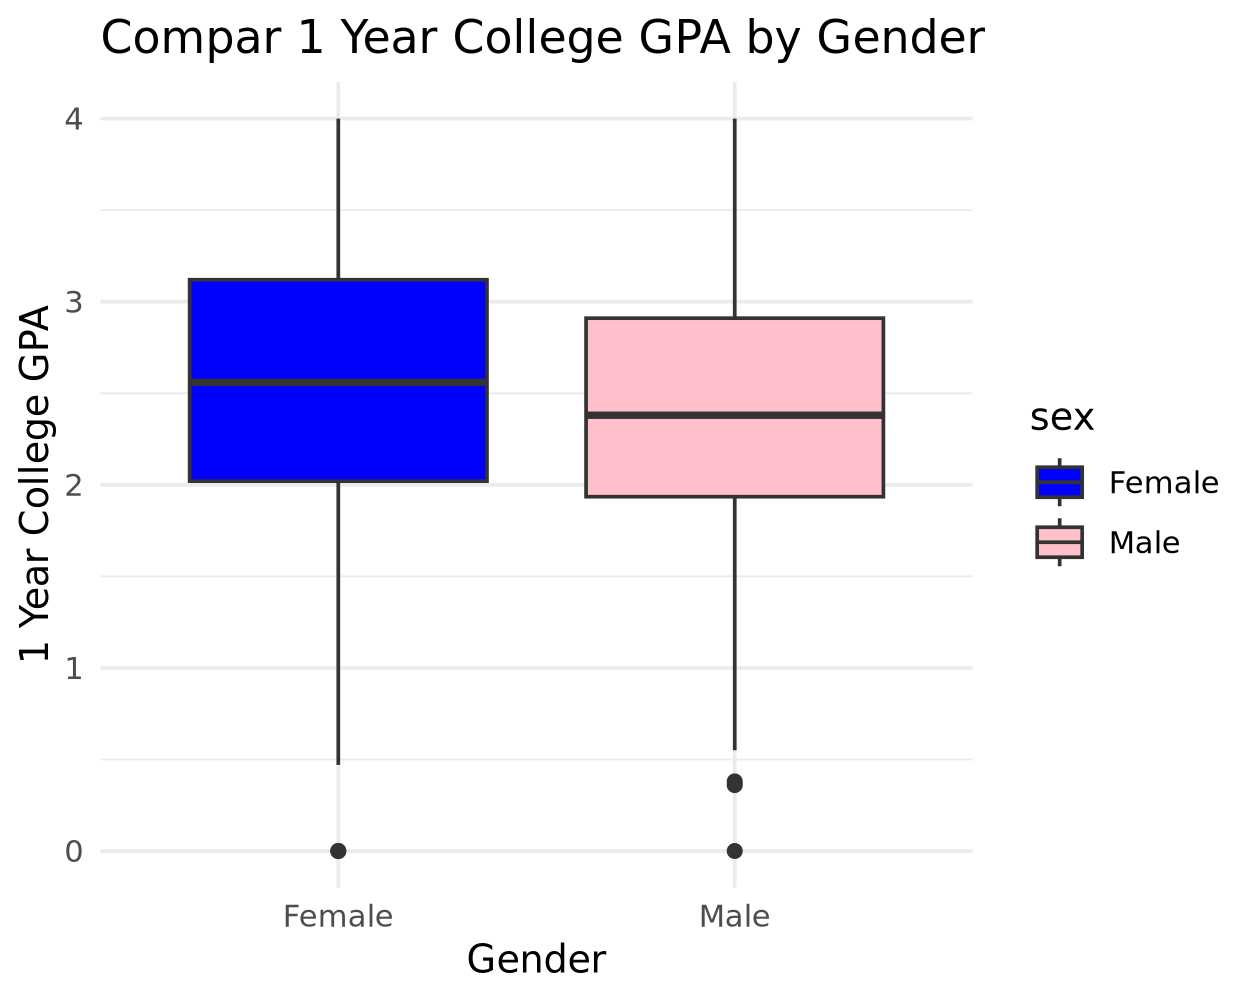

In [7]:
gpa_boxplot <- ggplot(sat_gpa, aes(x = sex, y = gpa_fy, fill = sex)) +
  geom_boxplot() +
  labs(title = "Compar 1 Year College GPA by Gender",
       x = "Gender",
       y = "1 Year College GPA") +
  theme_minimal() +
  scale_fill_manual(values = c("blue", "pink"))

print(gpa_boxplot)



## Stating a null hypothesis

We will now test the null hypothesis that there’s no difference in
population mean GPA between the genders at the population level. We can
write this out in mathematical notation

$$\begin{aligned} H_0:&\mu_{female} = \mu_{male} \\\ \mbox{vs }H_A:& \mu_{female} \neq \mu_{male} \end{aligned}$$

or expressed differently, that the difference is 0 or not:

$$\begin{aligned} H_0:&\mu_{female} - \mu_{male} = 0 \\\ \mbox{vs }H_A:& \mu_{female} - \mu_{male} \neq 0 \end{aligned}$$

## Testing the hypothesis

Here’s how we use the `infer` package to conduct this hypothesis test:

### Step 1: Calculate the observed difference

Note that the order we choose does not matter here (female then
male)…but since we used `order = c("Female", "Male")` here, we should do
the same in subsequent calculations!

In [8]:
obs_diff_gpa_sex = sat_gpa |>
  specify(gpa_fy ~ sex) |>
  calculate(stat = "diff in means", order = c("Female", "Male"))

obs_diff_gpa_sex

stat
<dbl>
0.1485209


Note that this is the difference in the group means we calculated
earlier!

In [9]:
2.544587 - 2.396066

[1] 0.148521

### Step 2. Generate the null distribution of $\delta$

This step involves generating simulated values *as if* we lived in a
world where there’s no difference between the two groups. Going back to
the idea of permutation, and tactile sampling, this is akin to shuffling
the GPA scores between male and female labels (i.e. removing the
structure to the data) just as we could have done with index cards.

In [10]:
gpas_in_null_world = sat_gpa |> 
  specify(gpa_fy ~ sex) |> 
  hypothesize(null = "independence") |>
  generate(reps = 5000, type = 'permute')

gpas_in_null_world |> head()

gpa_fy,sex,replicate
<dbl>,<fct>,<int>
1.94,Male,1
3.10,Female,1
2.83,Female,1
2.67,Male,1
3.13,Male,1
1.12,Female,1


## Q1.c)

**Question**:

1.  What was the size of the “shuffled” (permuted) sample in each run?
2.  How many times did we “shuffle” (permute) the sample? How many rows
    are in the `gpas_in_null_world` data frame?

**Answer:**

1. The size of the shuffled permuted sample in each run was 1,000, which is the total number of students. 
2. The sample was shuffled permuted 5,000 times, resulting in a gpas_in_null_world data frame with 5,000,000 rows.

### Step 3. Calculate the differences between male and females under the null

The following calculates the differences in mean GPA for males and
females for “shuffled” (permuted) data.

In [11]:
gpa_diff_under_null = gpas_in_null_world |>
  calculate(stat = "diff in means", order = c("Female", "Male")) 

gpa_diff_under_null |> 
  head()

replicate,stat
<int>,<dbl>
1,0.009298321
2,-0.048881254
3,0.052662727
4,0.009938978
5,0.014463611
6,0.017306522


## Q1.d)

**Question**:

1.  How many rows are in this data frame? Why?

**Answer:**

1.  The data frame gpa_diff_under_null has 5,000 rows, one for each of the 5,000 permutations performed.

### Step 4. Visualize how the observed difference compares to the null distribution of $\delta$

The following plots the $\delta$ values we calculated for each of the
different “shuffled” replicates. This is the null distribution of
$\delta$. The red line shows the observed difference between male and
female scores in the data (-0.1485209) from step 1.

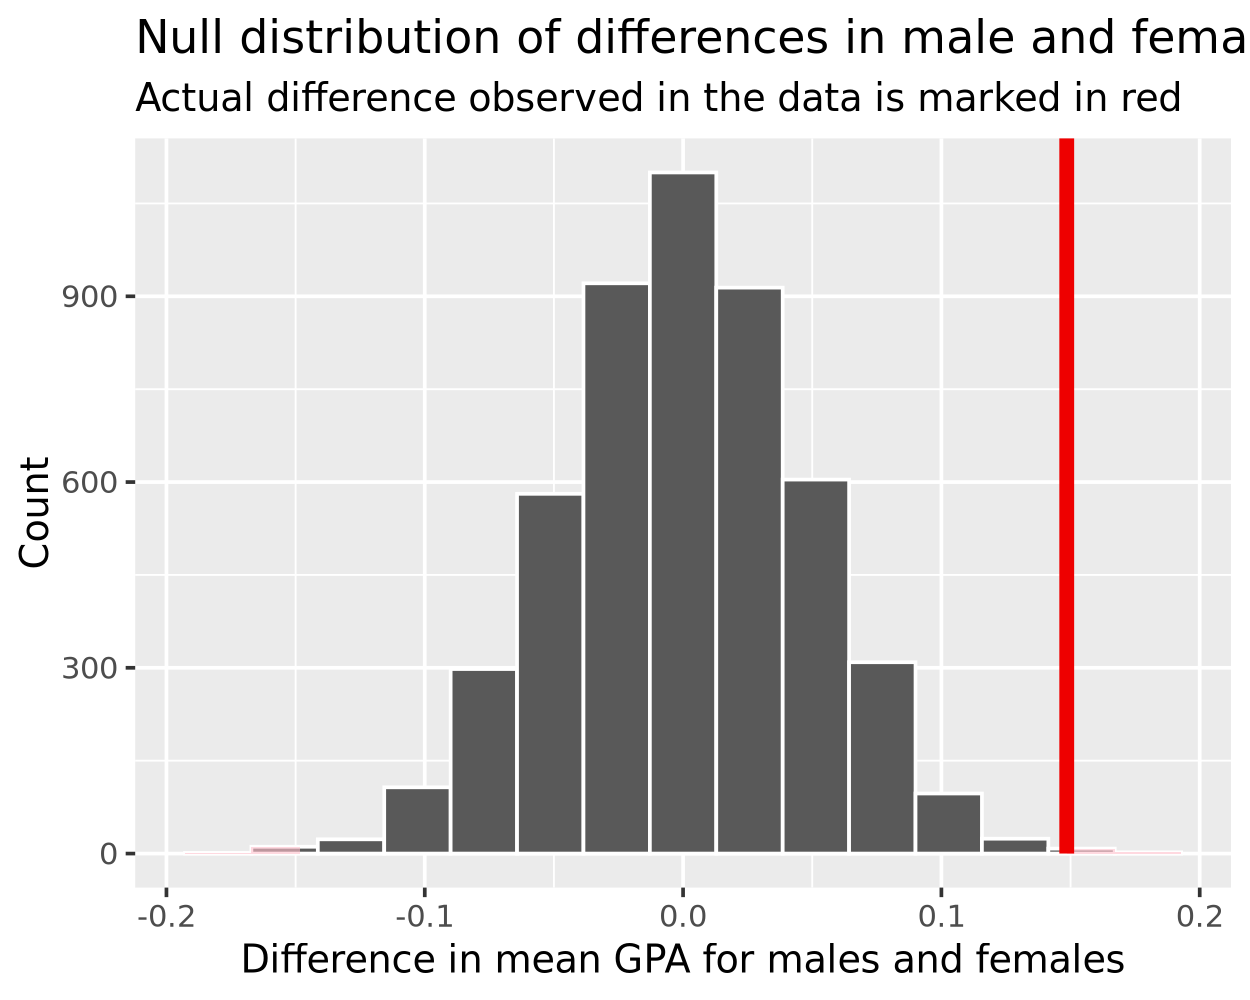

In [12]:
visualize(gpa_diff_under_null) +
  shade_p_value(obs_stat = obs_diff_gpa_sex, direction = "both") +
  labs(x = "Difference in mean GPA for males and females", y = "Count",
       title = "Null distribution of differences in male and female GPAs",
       subtitle = "Actual difference observed in the data is marked in red"
       )

**Note that zero is the center of this null distribution.** The null
hypothesis is that there is no difference between males and females in
GPA score. In the permutations, zero was the most common difference,
because observed GPA values were re-assigned to males and females **at
random**. Differences as large as \~ 0.1 and -0.1 occurred, but much
less frequently, because they are just not as likely when structure is
removed from the data.

### Step 5: Calculate a p-value

In [13]:
gpa_diff_under_null %>% 
  get_pvalue(obs_stat = obs_diff_gpa_sex, direction = "both") 

p_value
<dbl>
0.0028


This result indicates that there is a 0.1% chance (very low) chance that
we would see a difference of 0.15 in GPA scores between males and
females (or a bigger difference) if in fact there was truly no
difference between the sexes in GPA scores in the population.

## Q1.e)

Fill in the blanks below to write up the results & conclusions for this
test:

The mean GPA scores for females in our sample ($\bar{x}$ = 2.5)
was greater than that of males ($\bar{x}$ = 2.3). This
difference **(was)**\_ statistically significant at
$\alpha = 0.05$, (p = 0.0028). Given this I **(would)** reject the Null hypothesis and conclude that females have
higher GPAs than males at the population level.

### Step 6: Calculate a confidence interval for the difference

The following will allow us to calculate a 95% confidence interval for
the difference between mean GPA scores for males and females.

In [14]:
ci_diff_gpa_means <- sat_gpa %>% 
  specify(gpa_fy ~ sex) %>%
  generate(reps = 5000, type = "bootstrap") %>% 
  calculate(stat = "diff in means", order = c("Female", "Male")) %>% 
  get_confidence_interval(level = 0.95)

ci_diff_gpa_means

lower_ci,upper_ci
<dbl>,<dbl>
0.05779147,0.2391502


## Complete all the above tasks with a t-test

Note that all the above steps can be done with one line of code **if a
slew of assumptions** like normality and equal variance of the groups
are met.

In [15]:
t.test(gpa_fy ~ sex, var.equal = TRUE, data = sat_gpa)


	Two Sample t-test

data:  gpa_fy by sex
t = 3.1828, df = 998, p-value = 0.001504
alternative hypothesis: true difference in means between group Female and group Male is not equal to 0
95 percent confidence interval:
 0.05695029 0.24009148
sample estimates:
mean in group Female   mean in group Male 
            2.544587             2.396066 


## Question 2: Relationship between high-school GPA category and Total SAT score?

For this analysis `sat_total` is the outcome variable, and `gpa_hs` is
the predictor variable, with two levels “low” and “high”. For this
question, let’s use a pre-determined $\alpha$ significance-level of
0.10, which is considered a more liberal significance-level than 0.05
since p-values will have an easier time being less than $\alpha$, and
thus we are likely to reject the null hypothesis $H_0$ more often.

## Exploratory data analysis

We can first calculate the mean total SAT score for each group (i.e
students with a low and high GPA), using the `group_by` and `summarize`
commands from the `dplyr` package.

In [16]:
avg_sat_gpa <- sat_gpa %>% 
  group_by(gpa_hs) %>% 
  summarize(sat_total = mean(sat_total))

avg_sat_gpa

gpa_hs,sat_total
<chr>,<dbl>
high,108.67828
low,98.23047


We will next generate a data visualization that displays the total SAT
scores of the two groups. Be sure to include a title and label your
axes.

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


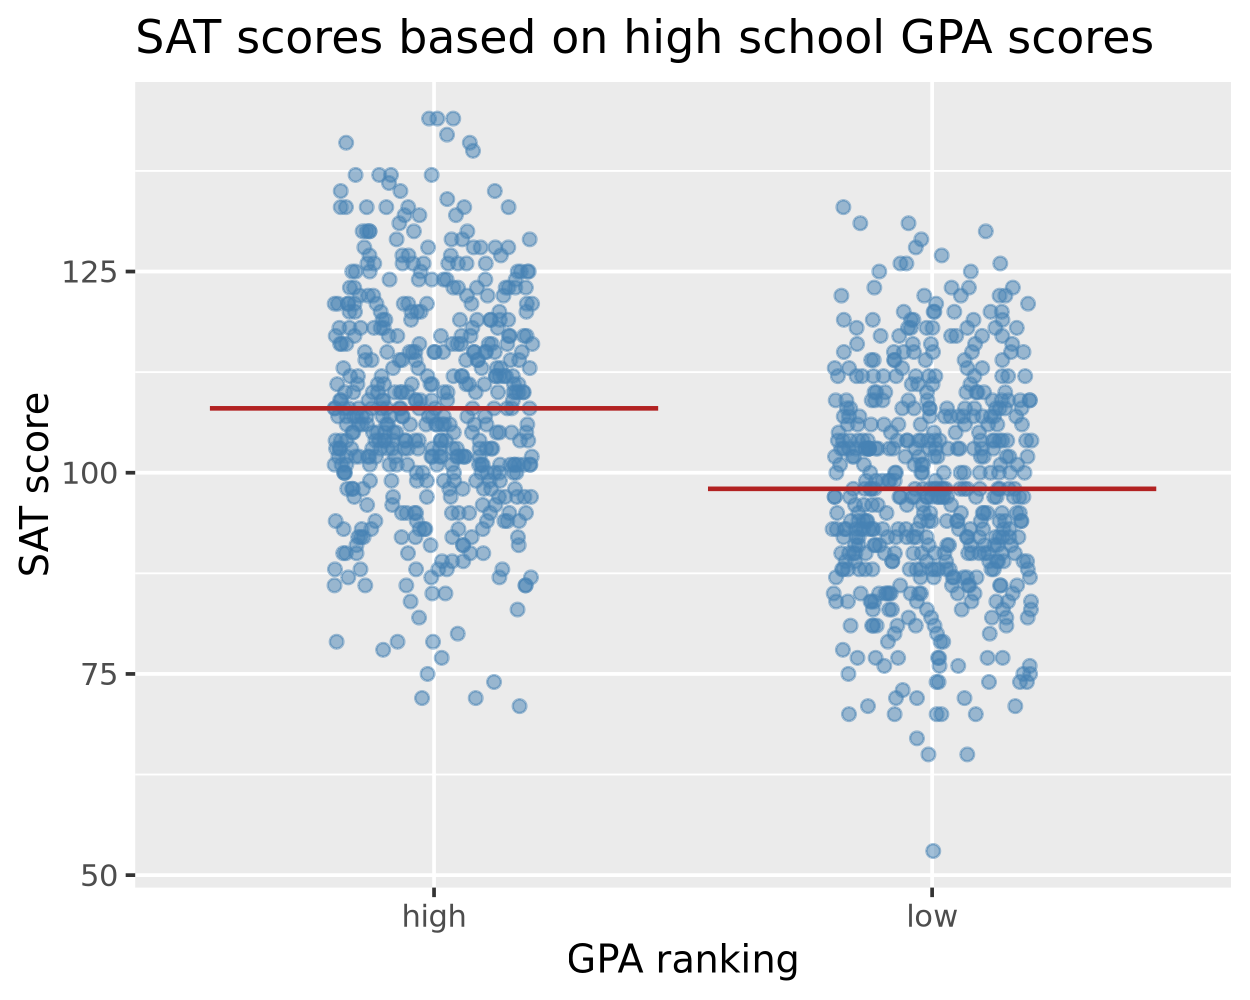

In [17]:
ggplot(sat_gpa, aes(x = gpa_hs, y = sat_total)) + 
    geom_point(fill = "darkgreen", position = position_jitter(height = 0, width = 0.2), alpha = 0.5, color = 'steelblue') + 
    stat_summary(geom = 'crossbar', fun = median, color = 'firebrick', size = 0.25, alpha = 0.6) +
    labs(title = "SAT scores based on high school GPA scores", 
       x = "GPA ranking", y = "SAT score")

## Stating a null hypothesis

## Q2.a)

State the null hypothesis that you are testing (using either words or
symbols)

**Answer:**

1. The null hypothesis is that high school GPA category has no effect on total SAT scores

## Testing the hypothesis

## Q2.b)

Calculate the observed difference between the mean total SAT scores of
the low and high GPA high-school students.

In [18]:
obs_diff_sat_hs_gpa <- sat_gpa %>%
  group_by(gpa_hs) %>%
  summarize(mean_sat_total = mean(sat_total, na.rm = TRUE)) %>%
  spread(gpa_hs, mean_sat_total) %>%
  mutate(obs_diff = high - low) %>%
  pull(obs_diff)

obs_diff_sat_hs_gpa

[1] 10.44781

## Q2.c)

Generate the null distribution of $\delta$. Here you need to generate
simulated values *as if* we lived in a world where there’s no difference
in SAT scores between high school students with low and high GPAs.

In [19]:
sat_in_null_world <- sat_gpa %>%
  specify(formula = sat_total ~ gpa_hs) %>%
  hypothesize(null = "independence") %>%
  generate(reps = 1000, type = "permute") %>%
  calculate(stat = "diff in means", order = c("high", "low"))

sat_in_null_world

replicate,stat
<int>,<dbl>
1,-0.538518186
2,-0.774654201
3,0.145876025
4,-0.290375256
5,-0.082255379
6,-0.278368340
7,0.742219518
8,-1.439036885
9,0.193903689


## Q2.d)

Calculate the differences in mean SAT scores between students with low
and high GPA scores under the Null. Note…you should use whatever order
you chose above…i.e. `order = c("low", "high")` or
`order = c("high", "low")`.

In [20]:
sat_diff_under_null <- sat_gpa %>%
  specify(sat_total ~ gpa_hs) %>%
  hypothesize(null = "independence") %>%
  generate(reps = 1000, type = "permute") %>%
  calculate(stat = "diff in means", order = c("high", "low"))

sat_diff_under_null


replicate,stat
<int>,<dbl>
1,0.51408811
2,-1.24692623
3,-0.58654585
4,-0.31438909
5,0.93433017
6,0.52209273
7,0.26194288
8,-1.10284324
9,-0.04623463


## Q2.e)

Visualize how the observed difference compares to the null distribution
of $\delta$. Generate a histogram of the null distribution, with a
vertical red line showing the observed difference in SAT scores between
high school students with a high and low GPA.

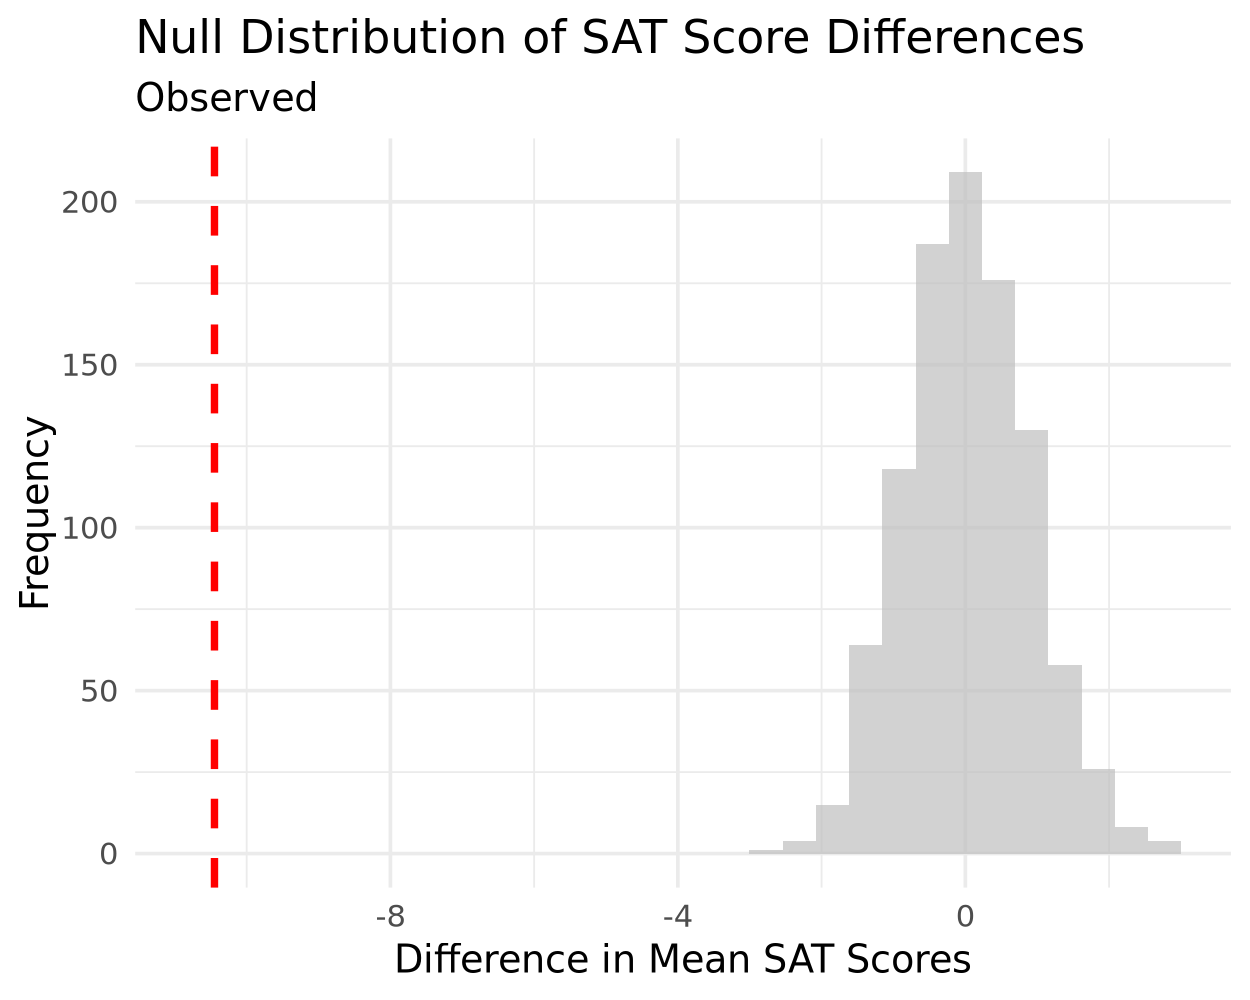

In [25]:
obs_diff_sat_hs_gpa <- sat_gpa %>%
  group_by(gpa_hs) %>%
  summarize(mean_sat_total = mean(sat_total, na.rm = TRUE)) %>%
  summarize(obs_diff = diff(mean_sat_total)) %>%
  pull(obs_diff)

sat_diff_under_null %>%
  ggplot(aes(x = stat)) +
  geom_histogram(bins = 30, fill = "gray", alpha = 0.7) +
  geom_vline(aes(xintercept = obs_diff_sat_hs_gpa), color = "red", linetype = "dashed", size = 1) +
  labs(title = "Null Distribution of SAT Score Differences",
       subtitle = "Observed",
       x = "Difference in Mean SAT Scores",
       y = "Frequency") +
  theme_minimal()

## Q2.f)

Calculate a p-value

In [27]:
p_value <- sat_diff_under_null %>%
  get_p_value(obs_stat = obs_diff_sat_hs_gpa, direction = "greater") 

p_value

p_value
<dbl>
1


## Q2.g)

Write up the results & conclusions for this hypothesis test. Note,
p-values less than 0.001 are often reported as p \< 0.001.

**Answer:**

1. The p-value of 1.0 indicates no significant difference in SAT scores between students with high and low high school GPAs, suggesting that GPA does not impact SAT scores in this sample.  

## Q2.h)

Calculate a confidence interval for the difference in total SAT scores
for students with high and low high-school GPA scores. Note…you should
use whatever order you chose above…i.e. `order = c("low", "high")` or
`order = c("high", "low")`.

In [28]:
ci_diff_sat_means <- sat_gpa %>%
  specify(sat_total ~ gpa_hs) %>%
  hypothesize(null = "independence") %>%
  generate(reps = 1000, type = "permute") %>%
  calculate(stat = "diff in means", order = c("high", "low")) %>%
  get_confidence_interval(level = 0.95, type = "percentile")

ci_diff_sat_means

lower_ci,upper_ci
<dbl>,<dbl>
-1.671671,1.811836


## Q2.i)

Use a t-test to test the null hypothesis that total SAT scores do not
differ between students with high and low high school GPA scores at the
population level.

In [29]:
high_gpa_sat_scores <- filter(sat_gpa, gpa_hs == "high")$sat_total
low_gpa_sat_scores <- filter(sat_gpa, gpa_hs == "low")$sat_total

t_test_results <- t.test(high_gpa_sat_scores, low_gpa_sat_scores, alternative = "two.sided", var.equal = FALSE)

t_test_results




	Welch Two Sample t-test

data:  high_gpa_sat_scores and low_gpa_sat_scores
t = 12.407, df = 993.35, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  8.795323 12.100297
sample estimates:
mean of x mean of y 
108.67828  98.23047 
